In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-08-25 21:17:01,954: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-08-25 21:17:02,000: INFO: common: yaml file: params.yaml loaded successfully]
[2024-08-25 21:17:02,009: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-08-25 21:17:02,014: INFO: common: created directory at: artifacts]
[2024-08-25 21:17:02,017: INFO: common: created directory at: artifacts/data_ingestion]
[2024-08-25 21:17:02,020: INFO: common: Size of the file at: artifacts\data_ingestion\data.zip is ~ 1 KB]
[2024-08-25 21:17:02,022: INFO: 3959375373: File already exists of size: ~ 1 KB]
[2024-08-25 21:17:02,052: INFO: 3959375373: First few rows of the dataset:
   Angle of Sandblasting  Pressure of Sandblasting (bar)  \
0                     30                               3   
1                     40                               3   
2                     50                               3   
3                     30                               3   
4                 

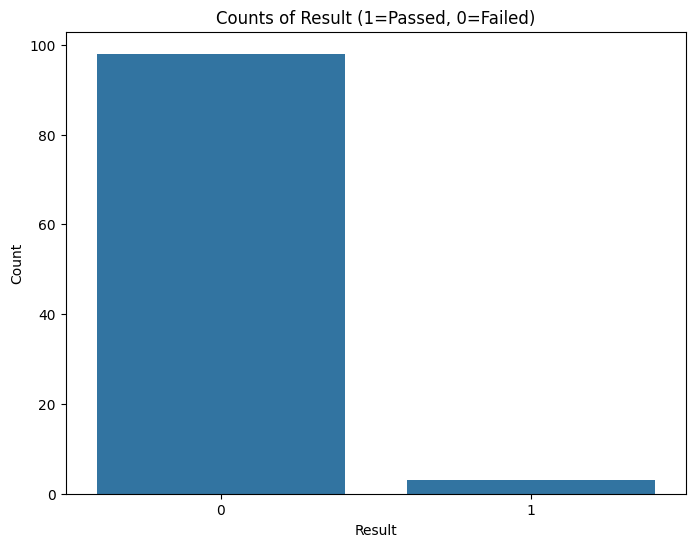

In [5]:
from dataclasses import dataclass
from pathlib import Path
from Dental_Implant_Sandblasting.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH
from Dental_Implant_Sandblasting.utils.common import read_yaml, create_directories, get_size
import urllib.request as request
from Dental_Implant_Sandblasting import logger
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Make data class (update the entity):
@dataclass(frozen=True)
class DataIngestionConfig:
    root_dir: Path
    source_URL: str
    local_data_file: Path
    unzip_dir: Path

### Configuration Manager in src config
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion

        create_directories([config.root_dir])

        data_ingestion_config = DataIngestionConfig(
            root_dir=config.root_dir,
            source_URL=config.source_URL,
            local_data_file=config.local_data_file,
            unzip_dir=config.unzip_dir
        )

        return data_ingestion_config

### Update the components:

### Class for downloading, extracting a data file, and performing EDA
class DataIngestion:
    def __init__(self, config: DataIngestionConfig):
        self.config = config

    # Method to download a file from a URL and save it locally
    def download_file(self):
        if not os.path.exists(self.config.local_data_file):
            filename, headers = request.urlretrieve(
                url=self.config.source_URL,
                filename=self.config.local_data_file
            )
            logger.info(f"{filename} downloaded! with following info: \n{headers}")
        else:
            logger.info(f"File already exists of size: {get_size(Path(self.config.local_data_file))}")

    # Method to extract the downloaded zip file into a specified directory
    def extract_zip_file(self):
        unzip_path = self.config.unzip_dir
        os.makedirs(unzip_path, exist_ok=True)
        with zipfile.ZipFile(self.config.local_data_file, 'r') as zip_ref:
            zip_ref.extractall(unzip_path)

    # Method to load data and perform basic EDA
    def load_and_explore_data(self):
        # Ensure unzip_dir is a Path object
        unzip_dir = Path(self.config.unzip_dir)

        # Load the dataset
        data_file_path = unzip_dir / "Sandblasting-Condition.csv"
        data = pd.read_csv(data_file_path)

        # Display first few rows of the dataset
        logger.info(f"First few rows of the dataset:\n{data.head()}")

        # Data shape
        logger.info(f"Data shape: {data.shape}")

        # Data types and basic info
        logger.info("Data info:")
        data.info()

        # Summary statistics
        logger.info(f"Summary statistics:\n{data.describe(include='all')}")

        # Check for missing values
        logger.info(f"Missing values by column:\n{data.isnull().sum()}")

        # Handle non-numeric values
        cols_to_convert = [
            'Pressure of Sandblasting (bar)',
            'Temperture of Acid Etching',
            'Time of Acid Etching (min)',
            'Voltage of Anodizing (v)',
            'Time of  Anodizing (min)',
            '(Sa) Average of Surface roughness (micrometer)',
            'Cell Viability (%)'
        ]
        data[cols_to_convert] = data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

        # Drop rows with NaN values in these columns
        data = data.dropna(subset=cols_to_convert)
        logger.info("Data types after cleaning:")
        logger.info(f"{data.dtypes}")

        # Filter data according to the given validation ranges
        valid_data = data[(data['(Sa) Average of Surface roughness (micrometer)'] > 1.5) &
                          (data['(Sa) Average of Surface roughness (micrometer)'] < 2.5)]

        # Set "Cell Viability (%)" to 0 where Sa is outside the valid range
        data.loc[~data.index.isin(valid_data.index), 'Cell Viability (%)'] = 0

        # Set Result (1=Passed, 0=Failed) based on Cell Viability threshold
        data['Result (1=Passed, 0=Failed)'] = np.where(data['Cell Viability (%)'] > 90, 1, 0)

        # Outlier analysis for Cell Viability
        cv_threshold = data['Cell Viability (%)'].quantile(0.99)
        outliers = data[data['Cell Viability (%)'] > cv_threshold]
        logger.info(f"Outliers in Cell Viability (Top 1%):\n{outliers}")

        # Remove outliers from the dataset
        data_cleaned = data[data['Cell Viability (%)'] <= cv_threshold]

        # Save cleaned data for later stages
        cleaned_data_path = Path(self.config.root_dir) / "cleaned_data.csv"
        data_cleaned.to_csv(cleaned_data_path, index=False)
        logger.info(f"Cleaned data saved to {cleaned_data_path}")

        # Visualizations (Optional: Can be saved as files if needed)
        plt.figure(figsize=(8, 6))
        sns.countplot(x='Result (1=Passed, 0=Failed)', data=data_cleaned)
        plt.title("Counts of Result (1=Passed, 0=Failed)")
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.show()


### Update the Pipeline
try:
    config = ConfigurationManager()
    data_ingestion_config = config.get_data_ingestion_config()
    data_ingestion = DataIngestion(config=data_ingestion_config)
    data_ingestion.download_file()
    data_ingestion.extract_zip_file()
    data_ingestion.load_and_explore_data()  # Perform EDA after data is loaded and extracted
except Exception as e:
    logger.exception(e)
    raise e
